In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
spark = SparkSession.builder.appName('Iteration 4_Sly').getOrCreate()
import matplotlib.pyplot as plt
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
df = spark.read.csv('./AppleStore.csv', header=True)

In [3]:
df3 = df
df3 = df3.withColumnRenamed('_c0','No').withColumnRenamed('id','ID').withColumnRenamed('track_name','AppName')
df3 = df3.withColumnRenamed('size_bytes','AppSize_Bytes').withColumnRenamed('currency','Currency').withColumnRenamed('price','Price')
df3 = df3.withColumnRenamed('rating_count_tot','TotalRatingCount').withColumnRenamed('rating_count_ver','TotalRatingCount_CurrentVersion')
df3 = df3.withColumnRenamed('user_rating','UserRating').withColumnRenamed('user_rating_ver','UserRating_CurrentVersion')
df3 = df3.withColumnRenamed('ver','Version').withColumnRenamed('cont_rating','AppRestriction').withColumnRenamed('prime_genre','AppType')
df3 = df3.withColumnRenamed('sup_devices.num','SupportDeviceNum').withColumnRenamed('ipadSc_urls.num','DisplayedScreenshotNum')
df3 = df3.withColumnRenamed('lang.num','SupportLanguageNum').withColumnRenamed('vpp_lic','VppLicense')
df3 = df3.withColumn('No',df3.No.cast('int'))
df3 = df3.withColumn('ID',df3.ID.cast('int'))
df3 = df3.withColumn('AppSize_Bytes',df3.AppSize_Bytes.cast('int'))
df3 = df3.withColumn('Price',df3.Price.cast('float'))
df3 = df3.withColumn('TotalRatingCount',df3.TotalRatingCount.cast('int'))
df3 = df3.withColumn('TotalRatingCount_CurrentVersion',df3.TotalRatingCount_CurrentVersion.cast('int'))
df3 = df3.withColumn('UserRating',df3.UserRating.cast('float'))
df3 = df3.withColumn('UserRating_CurrentVersion',df3.UserRating_CurrentVersion.cast('float'))
df3 = df3.withColumn('SupportDeviceNum',df3.SupportDeviceNum.cast('int'))
df3 = df3.withColumn('DisplayedScreenshotNum',df3.DisplayedScreenshotNum.cast('int'))
df3 = df3.withColumn('SupportLanguageNum',df3.SupportLanguageNum.cast('int'))
df3 = df3.withColumn('VppLicense',df3.VppLicense.cast('int'))

In [4]:
null_rating =  df3.withColumn(
    'UserRating',
    when(
        col('UserRating') == 0, None
    ).otherwise(col('UserRating'))
)
df3 = null_rating
df3_1 = df3.na.drop(subset=['UserRating'])
rating_level = df3_1.withColumn(
    'UserRating',
    when(col('UserRating') <= 3.5, 'Low Rating').when(col('UserRating') > 3.5, 'High Rating')
)
rating_level = rating_level.withColumn('RatingLevel',rating_level.UserRating)
rating_level_2 = rating_level.select('ID','RatingLevel')
df3_2 = df3_1.join(rating_level_2, ['ID'], 'outer')
df3_2 = df3_2.drop('No','AppName','Currency','UserRating','UserRating_CurrentVersion','Version')

In [5]:
treat_outlier = df3_2.select('ID','AppSize_Bytes','TotalRatingCount','TotalRatingCount_CurrentVersion',
                             'SupportDeviceNum','SupportLanguageNum')

treat_outlier =  treat_outlier.withColumn('AppSize_Bytes',
    when(col('AppSize_Bytes') < 3900805.12, 3900805.12
        ).when((col('AppSize_Bytes') >= 3900805.12) & (col('AppSize_Bytes') <= 1.4759723622399957E9),col('AppSize_Bytes')
              ).when(col('AppSize_Bytes') > 1.4759723622399957E9, 1.4759723622399957E9)
) 
treat_outlier =  treat_outlier.withColumn('TotalRatingCount',
    when(col('TotalRatingCount') < 1.0, 1.0
        ).when((col('TotalRatingCount') >= 1.0) & (col('TotalRatingCount') <= 288713.30999999976),col('TotalRatingCount')
              ).when(col('TotalRatingCount') > 288713.30999999976, 288713.30999999976)
) 
treat_outlier =  treat_outlier.withColumn('TotalRatingCount_CurrentVersion',
    when(col('TotalRatingCount_CurrentVersion') < 0.0, 0.0
        ).when((col('TotalRatingCount_CurrentVersion') >= 0.0) & (col('TotalRatingCount_CurrentVersion') <= 7072.53999999999),
               col('TotalRatingCount_CurrentVersion')
              ).when(col('TotalRatingCount_CurrentVersion') > 7072.53999999999, 7072.53999999999)
)
treat_outlier =  treat_outlier.withColumn('SupportDeviceNum',
    when(col('SupportDeviceNum') < 24.0, 24.0
        ).when((col('SupportDeviceNum') >= 24.0) & (col('SupportDeviceNum') <= 43.0),col('SupportDeviceNum')
              ).when(col('SupportDeviceNum') > 43.0, 43.0)
)
treat_outlier =  treat_outlier.withColumn('SupportLanguageNum',
    when(col('SupportLanguageNum') < 1.0, 1.0
        ).when((col('SupportLanguageNum') >= 1.0) & (col('SupportLanguageNum') <= 34.0),col('SupportLanguageNum')
              ).when(col('SupportLanguageNum') > 34.0, 34.0)
)

data_divided_1 = df3_2.select('ID','AppSize_Bytes','Price','TotalRatingCount','TotalRatingCount_CurrentVersion',
                             'AppRestriction','AppType')
data_divided_2 = df3_2.select('ID','SupportDeviceNum','DisplayedScreenshotNum',
                              'SupportLanguageNum','VppLicense','RatingLevel')
df_merge = data_divided_1.join(data_divided_2, ['ID'], 'outer')
df4 = df_merge
df4 = df4.drop('AppSize_Bytes','TotalRatingCount','TotalRatingCount_CurrentVersion',
               'SupportDeviceNum','SupportLanguageNum')
df4 = df4.join(treat_outlier, ['ID'], 'outer')

In [6]:
boost_sample = df4.withColumn(
    'RatingLevel',
    when(col('RatingLevel') == 'Low Rating', 0).when(col('RatingLevel') == 'High Rating', 1)
)
pandassample = boost_sample.toPandas()
count_boost_x, count_boost_y = pandassample['RatingLevel'].value_counts()
boost_x = pandassample[pandassample['RatingLevel']==1]
boost_y = pandassample[pandassample['RatingLevel']==0]
oversample_y = boost_y.sample(count_boost_x, replace = True)

boost_x_values = boost_x.values.tolist()
boost_x_columns = boost_x.columns.tolist()
boost_x = spark.createDataFrame(boost_x_values, boost_x_columns)
oversample_y_values = oversample_y.values.tolist()
oversample_y_columns = oversample_y.columns.tolist()
oversample_y = spark.createDataFrame(oversample_y_values, oversample_y_columns)

boost_data = boost_x.union(oversample_y)

df4 = boost_data.withColumn(
    'RatingLevel',
    when(col('RatingLevel') == 0, 'Low Rating').when(col('RatingLevel') == 1, 'High Rating')
)
df4_1 = df4.select('AppSize_Bytes','Price','TotalRatingCount','TotalRatingCount_CurrentVersion',
                   'AppType','SupportDeviceNum','DisplayedScreenshotNum','SupportLanguageNum','RatingLevel')

In [7]:
#-----------------------------------------------------Step 7 Data Mining-----------------------------------------------------
df7 = df4_1
df7 = df7.withColumn(
    'AppType',
    when(col('AppType') == 'Games', 1).when(col('AppType') == 'Entertainment', 2)
    .when(col('AppType') == 'Education', 3).when(col('AppType') == 'Photo & Video', 4)
    .when(col('AppType') == 'Utilities', 5).when(col('AppType') == 'Social Networking', 6)
    .when(col('AppType') == 'Sports', 7).when(col('AppType') == 'Productivity', 8)
    .when(col('AppType') == 'Health & Fitness', 9).when(col('AppType') == 'Lifestyle', 10)
    .when(col('AppType') == 'Music', 11).when(col('AppType') == 'Shopping', 12)
    .when(col('AppType') == 'Finance', 13).when(col('AppType') == 'Weather', 14)
    .when(col('AppType') == 'News', 15).when(col('AppType') == 'Travel', 16)
    .when(col('AppType') == 'Food & Drink', 17).when(col('AppType') == 'Book', 18)
    .when(col('AppType') == 'Business', 19).when(col('AppType') == 'Reference', 20)
    .when(col('AppType') == 'Navigation', 21).when(col('AppType') == 'Medical', 22)
    .when(col('AppType') == 'Catalogs', 23)
)
df7 = df7.withColumn('AppType',df7.AppType.cast('double'))
df7 = df7.withColumn('DisplayedScreenshotNum',df7.DisplayedScreenshotNum.cast('double'))
df7.printSchema()

root
 |-- AppSize_Bytes: double (nullable = true)
 |-- Price: double (nullable = true)
 |-- TotalRatingCount: double (nullable = true)
 |-- TotalRatingCount_CurrentVersion: double (nullable = true)
 |-- AppType: double (nullable = true)
 |-- SupportDeviceNum: double (nullable = true)
 |-- DisplayedScreenshotNum: double (nullable = true)
 |-- SupportLanguageNum: double (nullable = true)
 |-- RatingLevel: string (nullable = true)



In [8]:
assembler = VectorAssembler(
  inputCols=['AppSize_Bytes','Price','TotalRatingCount','TotalRatingCount_CurrentVersion',
             'AppType','SupportDeviceNum','DisplayedScreenshotNum','SupportLanguageNum'],
              outputCol="features")
output = assembler.transform(df7)
indexer = StringIndexer(inputCol="RatingLevel", outputCol="RatingLevelIndex")
output_fixed = indexer.fit(output).transform(output)
final_data = output_fixed.select("features",'RatingLevelIndex')
final_data.show()

+--------------------+----------------+
|            features|RatingLevelIndex|
+--------------------+----------------+
|[6.907904E7,1.990...|             1.0|
|[1.66025216E8,0.0...|             1.0|
|[3.43504896E8,1.9...|             1.0|
|[2.43441664E8,0.0...|             1.0|
|[1.44820224E8,0.0...|             1.0|
|[1.87205632E8,0.0...|             1.0|
|[6.1046784E7,0.0,...|             1.0|
|[1.22903552E8,0.0...|             1.0|
|[9.66167552E8,29....|             1.0|
|[7.1191552E7,0.0,...|             1.0|
|[3.0896128E7,0.99...|             1.0|
|[4.748288E7,2.990...|             1.0|
|[7.29790464E8,0.0...|             1.0|
|[1.76520192E8,0.9...|             1.0|
|[5.056512E7,1.990...|             1.0|
|[9.1478016E7,0.0,...|             1.0|
|[6.29897216E8,2.9...|             1.0|
|[1.70858496E8,0.0...|             1.0|
|[3.60722432E8,0.0...|             1.0|
|[1.38277888E8,2.9...|             1.0|
+--------------------+----------------+
only showing top 20 rows



In [9]:
dtc = DecisionTreeClassifier(labelCol='RatingLevelIndex',featuresCol='features',maxDepth = 8, minInstancesPerNode = 2)
rfc = RandomForestClassifier(labelCol='RatingLevelIndex',featuresCol='features',maxDepth = 8, minInstancesPerNode = 2)

In [10]:
train_data,test_data = final_data.randomSplit([0.8,0.2])

dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)
dtc_predictions = dtc_model.transform(test_data)
rfc_predictions = rfc_model.transform(test_data)

In [11]:
print(dtc_model._call_java('toDebugString'))

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_495ebb76c7b58b05de0f) of depth 8 with 377 nodes
  If (feature 3 <= 32.0)
   If (feature 2 <= 360.0)
    If (feature 4 <= 1.0)
     If (feature 7 <= 1.0)
      If (feature 0 <= 2.7394048E7)
       If (feature 0 <= 7177216.0)
        If (feature 1 <= 0.9900000095367432)
         Predict: 1.0
        Else (feature 1 > 0.9900000095367432)
         Predict: 0.0
       Else (feature 0 > 7177216.0)
        If (feature 6 <= 3.0)
         If (feature 3 <= 0.0)
          Predict: 0.0
         Else (feature 3 > 0.0)
          Predict: 0.0
        Else (feature 6 > 3.0)
         If (feature 2 <= 10.0)
          Predict: 0.0
         Else (feature 2 > 10.0)
          Predict: 0.0
      Else (feature 0 > 2.7394048E7)
       If (feature 5 <= 40.0)
        If (feature 2 <= 191.0)
         If (feature 1 <= 4.989999771118164)
          Predict: 0.0
         Else (feature 1 > 4.989999771118164)
          Predict: 1.0
        Else (feature 2 > 19

In [12]:
rfc_model.featureImportances

SparseVector(8, {0: 0.0961, 1: 0.0758, 2: 0.2257, 3: 0.2224, 4: 0.1581, 5: 0.0476, 6: 0.0668, 7: 0.1075})

In [13]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol="RatingLevelIndex", predictionCol="prediction", metricName="accuracy")
pre_evaluator = MulticlassClassificationEvaluator(labelCol="RatingLevelIndex", predictionCol="prediction", metricName="weightedPrecision")
rec_evaluator = MulticlassClassificationEvaluator(labelCol="RatingLevelIndex", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="RatingLevelIndex", predictionCol="prediction", metricName="f1")

In [14]:
dtc_acc = acc_evaluator.evaluate(dtc_model.transform(train_data))
dtc_pre = pre_evaluator.evaluate(dtc_predictions)
dtc_rec = rec_evaluator.evaluate(dtc_predictions)
dtc_f1 = f1_evaluator.evaluate(dtc_predictions)
print('DecisionTree Data Model Accuracy: {0:2.2f}%'.format(dtc_acc*100))
print('DecisionTree Data Model Precision: {0:2.2f}%'.format(dtc_pre*100))
print('DecisionTree Data Model Recall: {0:2.2f}%'.format(dtc_rec*100))
print('DecisionTree Data Model F1 Score: {0:2.2f}%'.format(dtc_f1*100))

DecisionTree Data Model Accuracy: 78.50%
DecisionTree Data Model Precision: 74.76%
DecisionTree Data Model Recall: 73.39%
DecisionTree Data Model F1 Score: 73.16%


In [15]:
rfc_acc = acc_evaluator.evaluate(rfc_model.transform(train_data))
rfc_pre = pre_evaluator.evaluate(rfc_predictions)
rfc_rec = rec_evaluator.evaluate(rfc_predictions)
rfc_f1 = f1_evaluator.evaluate(rfc_predictions)
print('RandomForest Data Model Accuracy: {0:2.2f}%'.format(rfc_acc*100))
print('RandomForest Data Model Precision: {0:2.2f}%'.format(rfc_pre*100))
print('RandomForest Data Model Recall: {0:2.2f}%'.format(rfc_rec*100))
print('RandomForest Data Model F1 Score: {0:2.2f}%'.format(rfc_f1*100))

RandomForest Data Model Accuracy: 81.07%
RandomForest Data Model Precision: 78.58%
RandomForest Data Model Recall: 77.52%
RandomForest Data Model F1 Score: 77.40%


In [16]:
dtc_predictions.show()
rfc_predictions.show()

+--------------------+----------------+-------------+--------------------+----------+
|            features|RatingLevelIndex|rawPrediction|         probability|prediction|
+--------------------+----------------+-------------+--------------------+----------+
|[3900805.12,0.990...|             1.0| [167.0,47.0]|[0.78037383177570...|       0.0|
|[3900805.12,0.990...|             1.0| [340.0,48.0]|[0.87628865979381...|       0.0|
|[3900805.12,1.990...|             1.0| [167.0,47.0]|[0.78037383177570...|       0.0|
|[3900805.12,1.990...|             1.0| [340.0,48.0]|[0.87628865979381...|       0.0|
|[3900805.12,1.990...|             1.0|   [0.0,37.0]|           [0.0,1.0]|       1.0|
|[3900805.12,1.990...|             1.0|   [0.0,37.0]|           [0.0,1.0]|       1.0|
|[3923968.0,0.9900...|             1.0| [340.0,48.0]|[0.87628865979381...|       0.0|
|[4278742.0,1.9900...|             1.0| [10.0,104.0]|[0.08771929824561...|       1.0|
|[5415000.0,1.9900...|             1.0|   [0.0,37.0]| 

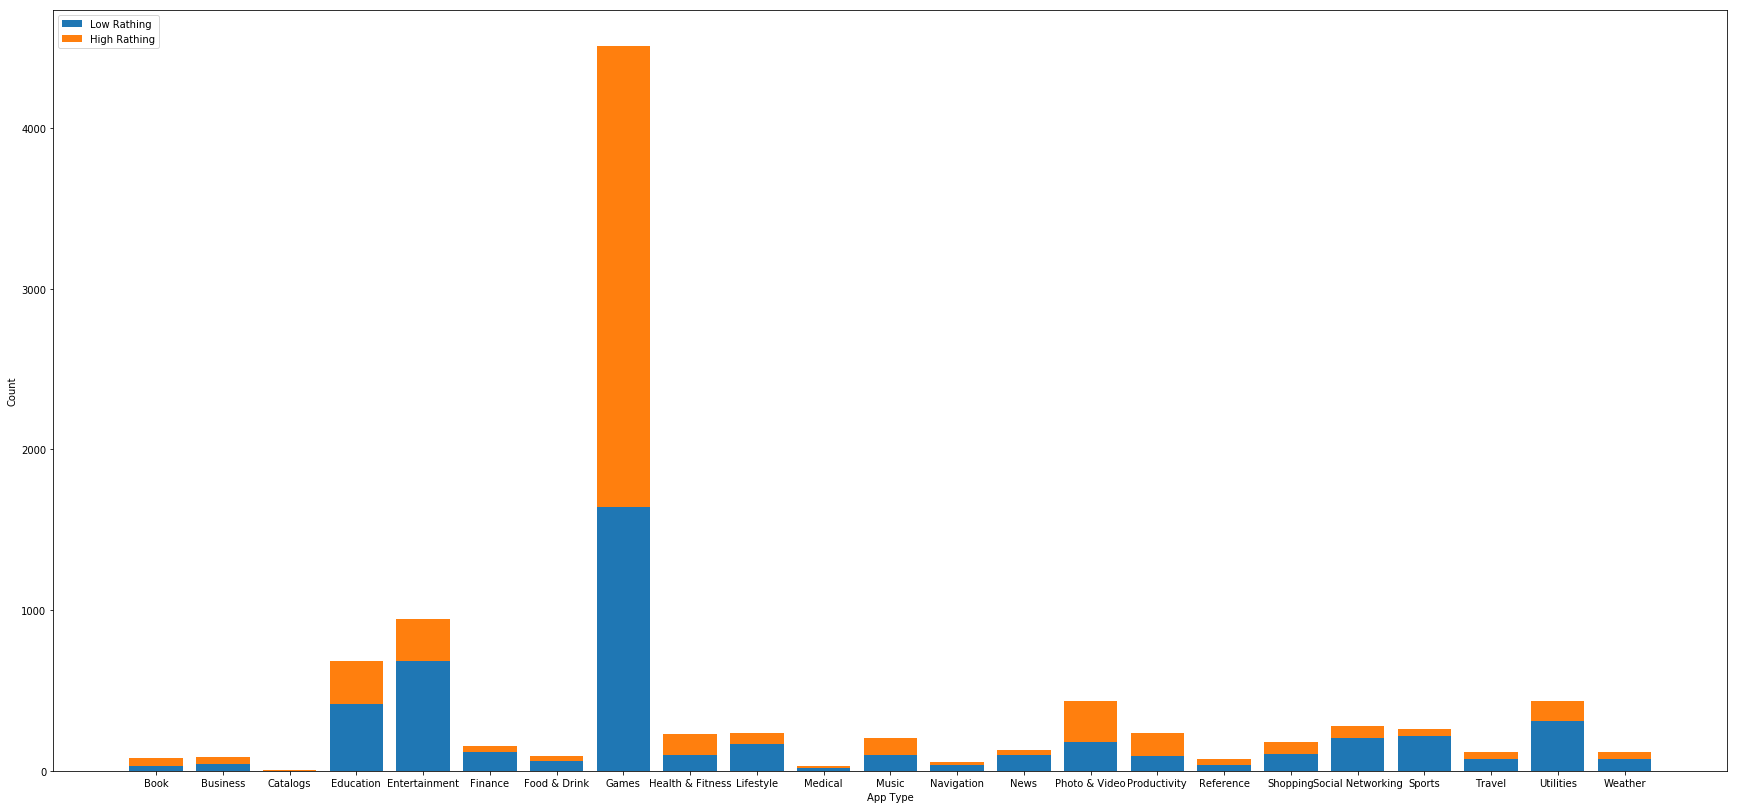

In [17]:
#---------------------------------------------------Step 8 Interpretation---------------------------------------------------
df8 = df4_1
plt.figure(figsize=(30,14))
df8_bar = df8.groupby('AppType').count().orderBy(df8.AppType.asc())
df8_bar_h = df8.filter(col('RatingLevel') == 'High Rating').groupby('AppType').count().orderBy(df8.AppType.asc())
df8_bar_l = df8.filter(col('RatingLevel') == 'Low Rating').groupby('AppType').count().orderBy(df8.AppType.asc())
df8_bar_x = df8_bar.toPandas()['AppType'].values.tolist()
df8_barh_y = df8_bar_h.toPandas()['count'].values.tolist()
df8_barl_y = df8_bar_l.toPandas()['count'].values.tolist()
plt.bar(df8_bar_x,df8_barl_y,width = 0.8,label = 'Low Rathing')
plt.bar(df8_bar_x,df8_barh_y,width = 0.8,bottom = df8_barl_y,label = 'High Rathing')
plt.xlabel('App Type')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.show()

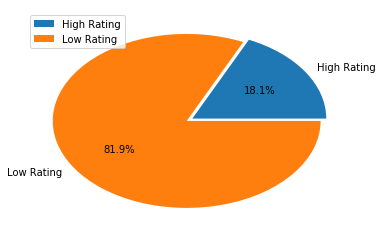

In [18]:
df8_pie = df8.groupby('RatingLevel').sum('TotalRatingCount_CurrentVersion')
df8_pie_x = df8_pie.toPandas()['sum(TotalRatingCount_CurrentVersion)'].values.tolist()
plt.pie(df8_pie_x,labels=['High Rating','Low Rating'], autopct='%.1f%%',explode=[0,0.05])
plt.legend(loc='upper left')
plt.show()

In [19]:
#df8.toPandas().to_csv('./AppleStore_DataMining.csv', header=True)

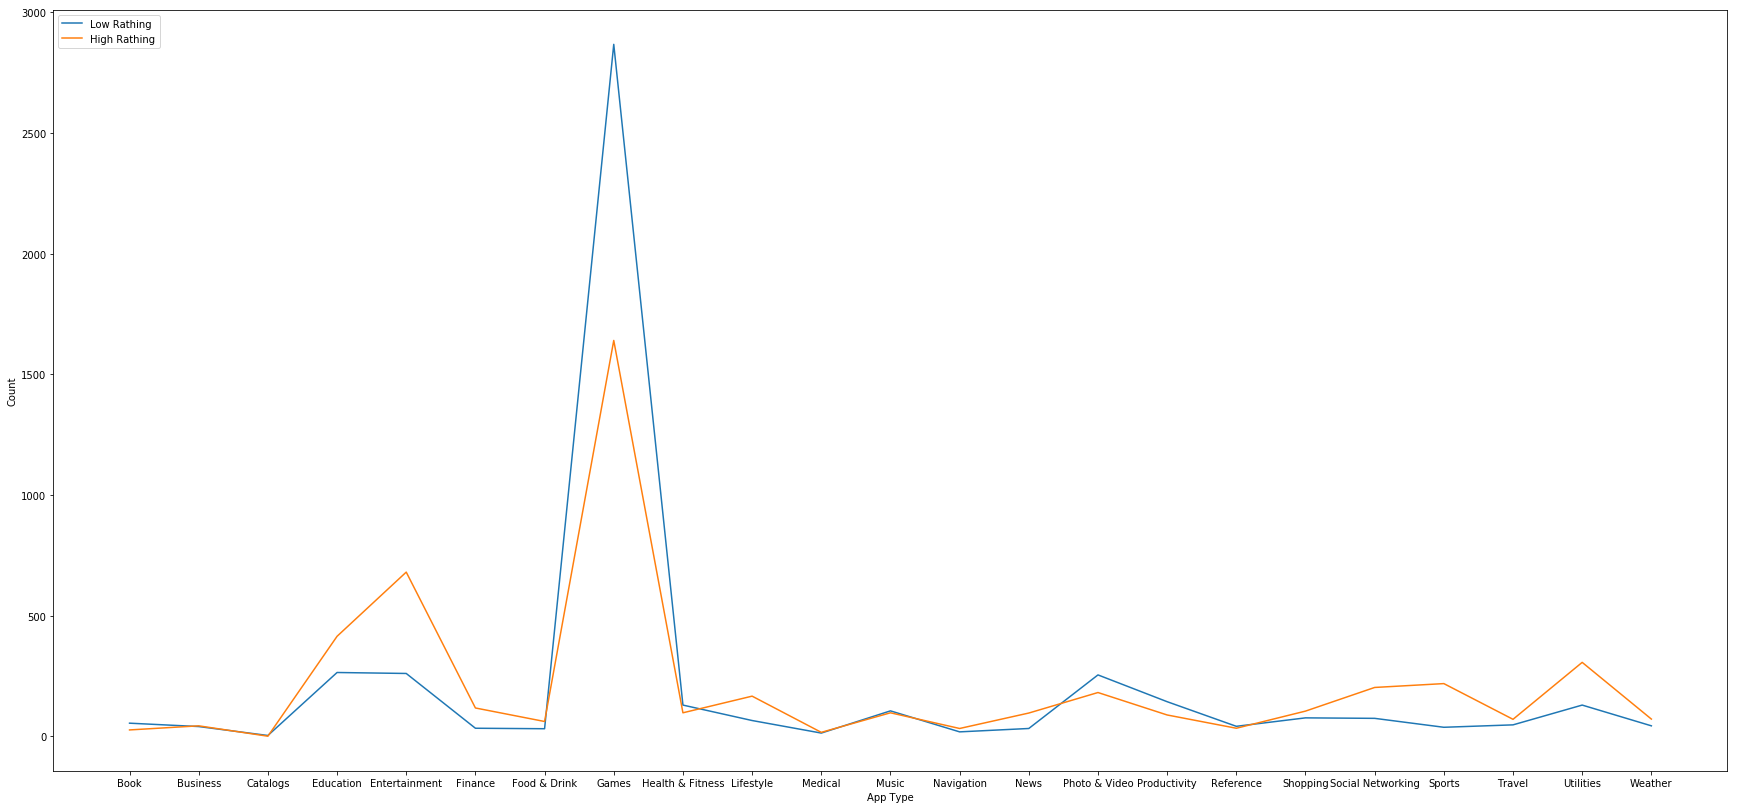

In [20]:
plt.figure(figsize=(30,14))
df8_plot = df8.groupby('AppType').count().orderBy(df8.AppType.asc())
df8_plot_h = df8.filter(col('RatingLevel') == 'High Rating').groupby('AppType').count().orderBy(df8.AppType.asc())
df8_plot_l = df8.filter(col('RatingLevel') == 'Low Rating').groupby('AppType').count().orderBy(df8.AppType.asc())
df8_plot_x = df8_plot.toPandas()['AppType'].values.tolist()
df8_ploth_y = df8_plot_h.toPandas()['count'].values.tolist()
df8_plotl_y = df8_plot_l.toPandas()['count'].values.tolist()
plt.plot(df8_plot_x,df8_ploth_y,label = 'Low Rathing')
plt.plot(df8_plot_x,df8_plotl_y,label = 'High Rathing')
plt.xlabel('App Type')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.show()

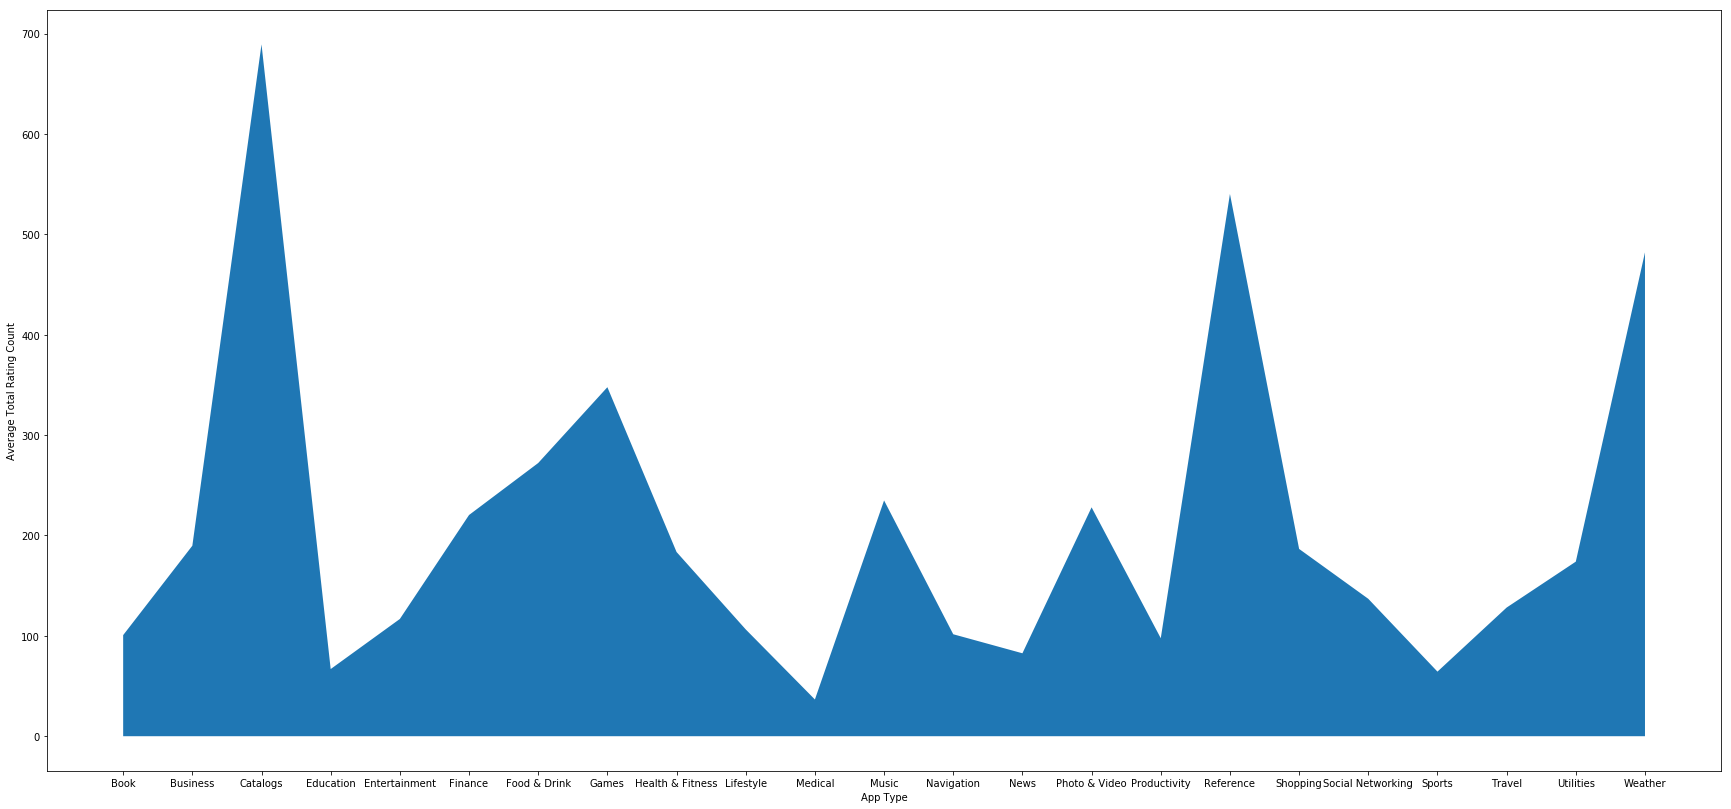

In [21]:
plt.figure(figsize=(30,14))
df8_bar2 = df8.groupby('AppType').avg('TotalRatingCount_CurrentVersion').orderBy(df8.AppType.asc())
df8_bar2_x = df8_bar2.toPandas()['AppType'].values.tolist()
df8_bar2_y = df8_bar2.toPandas()['avg(TotalRatingCount_CurrentVersion)'].values.tolist()
plt.stackplot(df8_bar_x,df8_bar2_y)
plt.xlabel('App Type')
plt.ylabel('Average Total Rating Count')
plt.show()

In [22]:
df8_1 = df4.select('AppSize_Bytes','Price','AppRestriction','AppType','SupportDeviceNum',
                   'DisplayedScreenshotNum','SupportLanguageNum','RatingLevel')
df8_1 = df8_1.withColumn(
    'Price',
    when(col('Price') == 0, 'Free').when(col('Price') > 0, 'Paid')
)
df8_1 = df8_1.withColumnRenamed('Price','PriceLevel')
df8_1.columns

['AppSize_Bytes',
 'PriceLevel',
 'AppRestriction',
 'AppType',
 'SupportDeviceNum',
 'DisplayedScreenshotNum',
 'SupportLanguageNum',
 'RatingLevel']

In [23]:
print(df8_1.count(),len(df8_1.columns))

9562 8


In [24]:
df8_2 = df8_1.filter("AppType in ('Games','Music','Photo & Video','Reference')")
df8_2 = df8_2.filter(col('RatingLevel')=='High Rating')
df8_2.show()

+-------------+----------+--------------+-------------+----------------+----------------------+------------------+-----------+
|AppSize_Bytes|PriceLevel|AppRestriction|      AppType|SupportDeviceNum|DisplayedScreenshotNum|SupportLanguageNum|RatingLevel|
+-------------+----------+--------------+-------------+----------------+----------------------+------------------+-----------+
| 3.43504896E8|      Paid|           12+|        Games|            37.0|                     5|               1.0|High Rating|
| 2.43441664E8|      Free|            4+|        Games|            38.0|                     5|               1.0|High Rating|
| 1.87205632E8|      Free|            9+|        Games|            37.0|                     5|              11.0|High Rating|
|  6.1046784E7|      Free|            9+|Photo & Video|            37.0|                     5|               8.0|High Rating|
| 1.22903552E8|      Free|           12+|        Games|            38.0|                     5|              15

In [25]:
print(df8_2.count(),len(df8_2.columns))

3271 8


In [26]:
feature_new = df8_2.select('AppSize_Bytes','AppRestriction','AppType','SupportDeviceNum',
                           'DisplayedScreenshotNum','SupportLanguageNum','PriceLevel')
feature_data_new = feature_new.withColumn(
    'AppRestriction',
    when(col('AppRestriction') == '4+', 1).when(col('AppRestriction') == '12+', 2)
    .when(col('AppRestriction') == '9+', 3).when(col('AppRestriction') == '17+', 4)
)
feature_data_new = feature_data_new.withColumn(
    'AppType',
    when(col('AppType') == 'Games', 1).when(col('AppType') == 'Photo & Video', 2) 
    .when(col('AppType') == 'Music', 3).when(col('AppType') == 'Reference', 4)
)
feature_data_new = feature_data_new.withColumn(
    'PriceLevel',
    when(col('PriceLevel') == 'Free', 0).when(col('PriceLevel') == 'Paid', 1)
)
feature_data_new.show()

+-------------+--------------+-------+----------------+----------------------+------------------+----------+
|AppSize_Bytes|AppRestriction|AppType|SupportDeviceNum|DisplayedScreenshotNum|SupportLanguageNum|PriceLevel|
+-------------+--------------+-------+----------------+----------------------+------------------+----------+
| 3.43504896E8|             2|      1|            37.0|                     5|               1.0|         1|
| 2.43441664E8|             1|      1|            38.0|                     5|               1.0|         0|
| 1.87205632E8|             3|      1|            37.0|                     5|              11.0|         0|
|  6.1046784E7|             3|      2|            37.0|                     5|               8.0|         0|
| 1.22903552E8|             2|      1|            38.0|                     5|              15.0|         0|
| 9.66167552E8|             1|      1|            38.0|                     5|               8.0|         1|
|   4.748288E7|    

In [27]:
feature_assembler_new = VectorAssembler(
  inputCols=['AppSize_Bytes','AppRestriction','SupportDeviceNum',
             'DisplayedScreenshotNum','SupportLanguageNum','PriceLevel'],
              outputCol="Column")
feature_output_new = feature_assembler_new.transform(feature_data_new)
feature_indexer_new = StringIndexer(inputCol="AppType", outputCol="Output")
feature_output_fixed_new = feature_indexer_new.fit(feature_output_new).transform(feature_output_new)
final_feature_data_new = feature_output_fixed_new.select("Column",'Output')
RF = RandomForestRegressor().setLabelCol('Output').setFeaturesCol('Column').setMaxBins(64).setMaxDepth(16)
feature_model_new = RF.fit(final_feature_data_new)
feature_model_new.featureImportances

SparseVector(6, {0: 0.357, 1: 0.0936, 2: 0.1806, 3: 0.1115, 4: 0.1977, 5: 0.0597})

In [28]:
df8_3 = df8_2.select('AppSize_Bytes','AppRestriction','AppType','SupportDeviceNum',
                     'DisplayedScreenshotNum','SupportLanguageNum')
df8_3.columns

['AppSize_Bytes',
 'AppRestriction',
 'AppType',
 'SupportDeviceNum',
 'DisplayedScreenshotNum',
 'SupportLanguageNum']

In [29]:
new_iteration_assembler = VectorAssembler(
  inputCols=['AppSize_Bytes','AppRestriction','SupportDeviceNum',
                     'DisplayedScreenshotNum','SupportLanguageNum'],
              outputCol="features")
new_iteration_output = new_iteration_assembler.transform(feature_data_new)
new_iteration_indexer = StringIndexer(inputCol="AppType", outputCol="AppTypeIndex")
new_iteration_output_fixed = new_iteration_indexer.fit(new_iteration_output).transform(new_iteration_output)
new_iteration_data = new_iteration_output_fixed.select("features",'AppTypeIndex')

train_data_new,test_data_new = new_iteration_data.randomSplit([0.8,0.2])

dtc_new = DecisionTreeClassifier(labelCol='AppTypeIndex',featuresCol='features',maxDepth = 8, minInstancesPerNode = 2)
dtc_new_model = dtc_new.fit(train_data_new)
dtc_new_predictions = dtc_new_model.transform(test_data_new)
print(dtc_new_model._call_java('toDebugString'))

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4fa4960e72c3286a7759) of depth 8 with 237 nodes
  If (feature 2 <= 37.0)
   If (feature 0 <= 1.44881664E8)
    If (feature 4 <= 1.0)
     If (feature 0 <= 4.9652736E7)
      If (feature 2 <= 24.0)
       Predict: 2.0
      Else (feature 2 > 24.0)
       If (feature 0 <= 1.6656384E7)
        If (feature 3 <= 4.0)
         If (feature 3 <= 2.0)
          Predict: 1.0
         Else (feature 3 > 2.0)
          Predict: 0.0
        Else (feature 3 > 4.0)
         Predict: 2.0
       Else (feature 0 > 1.6656384E7)
        If (feature 3 <= 0.0)
         If (feature 0 <= 2.5718784E7)
          Predict: 1.0
         Else (feature 0 > 2.5718784E7)
          Predict: 0.0
        Else (feature 3 > 0.0)
         If (feature 3 <= 3.0)
          Predict: 0.0
         Else (feature 3 > 3.0)
          Predict: 0.0
     Else (feature 0 > 4.9652736E7)
      If (feature 3 <= 4.0)
       If (feature 2 <= 25.0)
        Predict: 2.0
       Else (fea

In [30]:
rfc_new = RandomForestClassifier(labelCol='AppTypeIndex',featuresCol='features',maxDepth = 8, minInstancesPerNode = 2)
rfc_new_model = rfc_new.fit(train_data_new)
rfc_new_predictions = rfc_new_model.transform(test_data_new)
rfc_new_model.featureImportances

SparseVector(5, {0: 0.3409, 1: 0.0782, 2: 0.1926, 3: 0.1362, 4: 0.2521})

In [31]:
acc_new_evaluator = MulticlassClassificationEvaluator(labelCol="AppTypeIndex", predictionCol="prediction", metricName="accuracy")
pre_new_evaluator = MulticlassClassificationEvaluator(labelCol="AppTypeIndex", predictionCol="prediction", metricName="weightedPrecision")
rec_new_evaluator = MulticlassClassificationEvaluator(labelCol="AppTypeIndex", predictionCol="prediction", metricName="weightedRecall")
f1_new_evaluator = MulticlassClassificationEvaluator(labelCol="AppTypeIndex", predictionCol="prediction", metricName="f1")

In [32]:
dtc_new_acc = acc_new_evaluator.evaluate(dtc_new_model.transform(train_data_new))
dtc_new_pre = pre_new_evaluator.evaluate(dtc_new_predictions)
dtc_new_rec = rec_new_evaluator.evaluate(dtc_new_predictions)
dtc_new_f1 = f1_new_evaluator.evaluate(dtc_new_predictions)
print('DecisionTree Data Model Accuracy: {0:2.2f}%'.format(dtc_new_acc*100))
print('DecisionTree Data Model Precision: {0:2.2f}%'.format(dtc_new_pre*100))
print('DecisionTree Data Model Recall: {0:2.2f}%'.format(dtc_new_rec*100))
print('DecisionTree Data Model F1 Score: {0:2.2f}%'.format(dtc_new_f1*100))

DecisionTree Data Model Accuracy: 91.06%
DecisionTree Data Model Precision: 82.16%
DecisionTree Data Model Recall: 86.94%
DecisionTree Data Model F1 Score: 84.06%


In [33]:
rfc_new_acc = acc_new_evaluator.evaluate(rfc_new_model.transform(train_data_new))
rfc_new_pre = pre_new_evaluator.evaluate(rfc_new_predictions)
rfc_new_rec = rec_new_evaluator.evaluate(rfc_new_predictions)
rfc_new_f1 = f1_new_evaluator.evaluate(rfc_new_predictions)
print('RandomForest Data Model Accuracy: {0:2.2f}%'.format(rfc_new_acc*100))
print('RandomForest Data Model Precision: {0:2.2f}%'.format(rfc_new_pre*100))
print('RandomForest Data Model Recall: {0:2.2f}%'.format(rfc_new_rec*100))
print('RandomForest Data Model F1 Score: {0:2.2f}%'.format(rfc_new_f1*100))

RandomForest Data Model Accuracy: 91.59%
RandomForest Data Model Precision: 84.57%
RandomForest Data Model Recall: 88.80%
RandomForest Data Model F1 Score: 85.37%


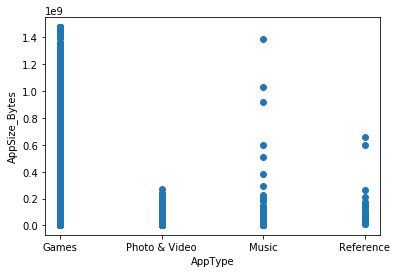

In [34]:
pandasdf8_3 = df8_3.toPandas()
plt.scatter(x=pandasdf8_3['AppType'], y=pandasdf8_3['AppSize_Bytes'])
plt.xlabel('AppType')
plt.ylabel('AppSize_Bytes')
plt.show()

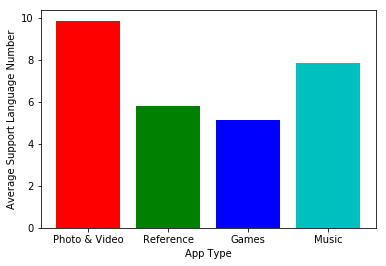

In [35]:
df8_3_bar = df8_3.groupby('AppType').avg('SupportLanguageNum')
df8_3_bar_x = df8_3_bar.toPandas()['AppType'].values.tolist()
df8_3_bar_y = df8_3_bar.toPandas()['avg(SupportLanguageNum)'].values.tolist()
plt.bar(df8_3_bar_x,df8_3_bar_y,color=['r','g','b','c'])
plt.xlabel('App Type')
plt.ylabel('Average Support Language Number')
plt.show()

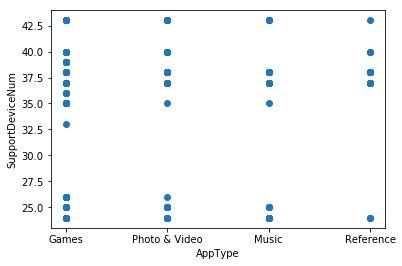

In [36]:
plt.scatter(x=pandasdf8_3['AppType'], y=pandasdf8_3['SupportDeviceNum'])
plt.xlabel('AppType')
plt.ylabel('SupportDeviceNum')
plt.show()

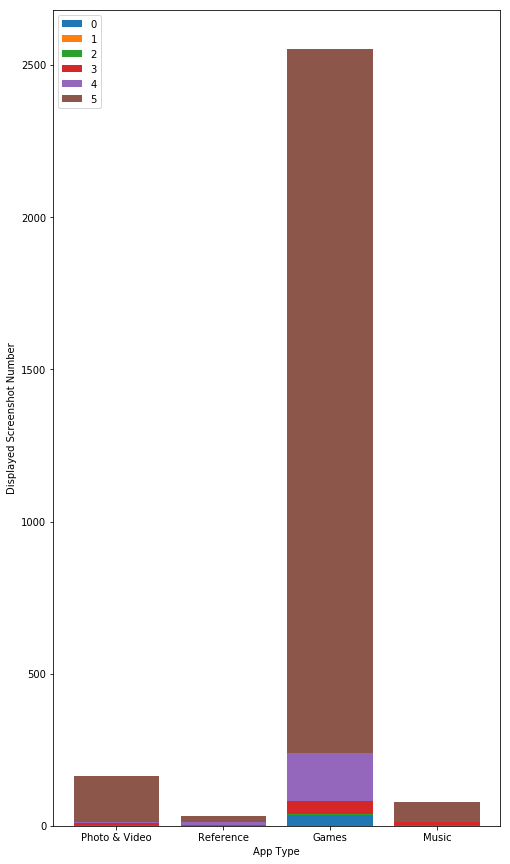

In [37]:
plt.figure(figsize=(8,15))
df8_3_bar2 = df8_3.groupby('AppType').count()
df8_3_bar2_1 = df8_3.filter(col('DisplayedScreenshotNum') == 0).groupby('AppType').count()
df8_3_bar2_2 = df8_3.filter(col('DisplayedScreenshotNum') == 1).groupby('AppType').count()
df8_3_bar2_3 = df8_3.filter(col('DisplayedScreenshotNum') == 2).groupby('AppType').count()
df8_3_bar2_4 = df8_3.filter(col('DisplayedScreenshotNum') == 3).groupby('AppType').count()
df8_3_bar2_5 = df8_3.filter(col('DisplayedScreenshotNum') == 4).groupby('AppType').count()
df8_3_bar2_6 = df8_3.filter(col('DisplayedScreenshotNum') == 5).groupby('AppType').count()
df8_3_bar2_x = df8_3_bar2.toPandas()['AppType'].values.tolist()
df8_3_bar2_y = df8_3_bar2_1.toPandas()['count'].values.tolist()
df8_3_bar2_y2 = df8_3_bar2_2.toPandas()['count'].values.tolist()
df8_3_bar2_y3 = df8_3_bar2_3.toPandas()['count'].values.tolist()
df8_3_bar2_y4 = df8_3_bar2_4.toPandas()['count'].values.tolist()
df8_3_bar2_y5 = df8_3_bar2_5.toPandas()['count'].values.tolist()
df8_3_bar2_y6 = df8_3_bar2_6.toPandas()['count'].values.tolist()
plt.bar(df8_3_bar2_x,df8_3_bar2_y,width = 0.8,label = '0')
plt.bar(df8_3_bar2_x,df8_3_bar2_y2,width = 0.8,bottom = df8_3_bar2_y,label = '1')
plt.bar(df8_3_bar2_x,df8_3_bar2_y3,width = 0.8,bottom = df8_3_bar2_y2,label = '2')
plt.bar(df8_3_bar2_x,df8_3_bar2_y4,width = 0.8,bottom = df8_3_bar2_y3,label = '3')
plt.bar(df8_3_bar2_x,df8_3_bar2_y5,width = 0.8,bottom = df8_3_bar2_y4,label = '4')
plt.bar(df8_3_bar2_x,df8_3_bar2_y6,width = 0.8,bottom = df8_3_bar2_y5,label = '5')
plt.xlabel('App Type')
plt.ylabel('Displayed Screenshot Number')
plt.legend(loc='upper left')
plt.show()